<a href="https://colab.research.google.com/github/SPThole/Pytorch-Tutorials/blob/master/Eng_Hindi_transliteration_attention_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Required Libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import dataset, DataLoader

from torch.utils.data import random_split
from tqdm import tqdm_notebook as tqdm

from sklearn.metrics import r2_score, accuracy_score
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.model_selection import train_test_split


# Geting data

In [ ]:
df = pd.read_csv('/content/crowd_transliterations.hi-en.txt',sep='\t',header=None)

In [ ]:
df.head()

,0,1
0,hajagiree,हजगिरी
1,chekaanv,चेकॉव
2,spinagaarn,स्पिनगार्न
3,medal,मेडल
4,chetthinaad,चेत्तिनाद


# Preprocessing

In [ ]:
d = {'<SOS>':1,
     '<EOS>':2}

In [ ]:
df['eng_len'] = df[0].apply(lambda x: len(list(x)))
df['hin_len'] = df[1].apply(lambda x: len(list(x)))

In [ ]:
max_input = df['hin_len'].max()
max_output = df['eng_len'].max()

In [ ]:
max_input, max_output

(21, 21)

In [ ]:
def name_to_idx(name,d):
  name1 = name
  for c in name1:
    if c not in list(d.keys()):
      d[c] = max(list(d.values()))+1
  return d

def form_dict(names,d,max_len):
  for n in tqdm(names):
    n1 = input_create(n,max_len)
    d = name_to_idx(n1,d)
  return d

def input_create(name,max_len):
  
  name1 = list(name)
  name1 = name1 + ['<EOS>']
  # for i in range(max_len -len(name1)):
  #   name1.append('<PAD>')
  return name1

def input_create1(name,max_len):
  
  name1 = list(name)
  name1 = ['<SOS>'] + name1
  name1 = name1 + ['<EOS>']
  # for i in range(max_len -len(name1)):
  #   name1.append('<PAD>')
  return name1

def one_hot(c,d):
  one_h = [0 for i in range(len(d))]
  one_h[d[c]] = 1
  return d[c]

In [ ]:
d_input = form_dict(df[0],
                        {'<SOS>':1,
                            '<EOS>':2,
                            '<PAD>':0},
                    21)
d_output = form_dict(df[1],
                     {'<SOS>':1,
                          '<EOS>':2,
                          '<PAD>':0},
                     21)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


In [ ]:
class mydata(DataLoader):
  
  def __init__(self,eng,hin):

    self.eng = eng
    self.hin = hin

  
  def __getitem__(self,idx):

    e = self.eng[idx]
    h = self.hin[idx]

    X = torch.tensor([one_hot(c,d_input) for c in input_create(list(e),21)]).float()
    X1= torch.tensor([one_hot(c,d_output) for c in input_create1(list(h),21)]).float()[:-1]


    Y = torch.tensor([d_output[s] for s in input_create1(list(h),21)])[1:]
    # Y = torch.tensor(X[1:]).float()
    return X,X1,Y

  def __len__(self):
    return len(self.eng)

In [ ]:
EOSI = torch.tensor(one_hot('<EOS>',d_input)).float()
SOSI = torch.tensor(one_hot('<SOS>',d_input)).float()
EOSO = torch.tensor(one_hot('<EOS>',d_output)).float()
SOSO = torch.tensor(one_hot('<SOS>',d_output)).float()

# Dataset

In [ ]:
from torch.nn.utils.rnn import pad_sequence,pad_packed_sequence
from torch.nn.utils.rnn import pack_padded_sequence
def padder(batch):

  (xx, xx1, yy) = zip(*batch)

  xx_lens = [len(xs) for xs in xx]
  xx1_lens = [len(xs) for xs in xx1]
  yy_lens = [len(yy) for ys in yy]

  xx_padded = pad_sequence(xx, batch_first= True, padding_value = 0)
  yy_padded = pad_sequence(yy, batch_first= True, padding_value = 0)
  xx1_padded = pad_sequence(xx1, batch_first= True, padding_value = 0)

  return xx_padded, xx1_padded, yy_padded, \
          xx_lens, xx1_lens, yy_lens






In [ ]:
data = mydata(df[0].values,df[1].values)

In [ ]:
train_dataset, test_dataset = random_split(data,[12000,2919])
train_loader = DataLoader(train_dataset,128,collate_fn=padder,drop_last=True)
test_loader = DataLoader(test_dataset,128,collate_fn=padder,drop_last=True)

In [ ]:
for Z in train_loader:
  print(Z[2].shape)
  break

torch.Size([128, 15])


# Models

In [ ]:
class encoder(nn.Module):

  def __init__(self,
               vocab_size,
               input_size,
               layers,
               hidden_size,
               output_size,
               batch_size):
    
    super(encoder, self).__init__()

    self.vocab_size = vocab_size
    self.input_size = input_size
    self.layers = layers
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.batch_size = batch_size


    self.emb = nn.Embedding(self.vocab_size,
                            self.input_size)

    self.rnn = nn.LSTM(input_size=input_size,
                       hidden_size = hidden_size,
                       dropout = 0.2,
                       num_layers = self.layers,
                       batch_first = True)
    
    self.fc = nn.Linear(self.hidden_size,self.output_size)
    
  def forward(self,x,x_lens):

    # print('ENCODER')
    
    h0 = torch.randn((self.layers,self.batch_size,self.hidden_size))
    c0 = torch.randn((self.layers,self.batch_size,self.hidden_size)) 

    # print('ENCODER H0,C0 INIT',h0.shape,c0.shape)


    x = self.emb(x.long())
    # print('EMBEDDED INPUT',x.shape)

    x_packed = pack_padded_sequence(x, 
                                    x_lens, 
                                    batch_first=True,
                                    enforce_sorted=False)
    

    out, (h1,c1) = self.rnn(x_packed,(h0,c0))
    out, _ = pad_packed_sequence(out, batch_first=True)

    # print('RNN OUTPUT',out.shape,h1.shape,c1.shape)

    out = self.fc(out)
    # print('FINAL ENCODER OUTPUT',out.shape)

    return out,h1,c1


class attn(nn.Module):

  def __init__(self,
               encoder_out_size,
               decoder_hidden_size,
               decoder_input_size):
    super(attn, self).__init__()

    self.enc_out = encoder_out_size
    self.dec_hid = decoder_hidden_size
    self.dec_in = decoder_input_size

    self.U = nn.Linear(self.enc_out,self.dec_in)
    self.W = nn.Linear(self.dec_hid,self.dec_in)

    self.attn_f = nn.Linear(self.dec_in,1)


  def forward(self,enc_out,dec_hidn):

    # print('ATTENTION')
    
    # print('Enc out shape',enc_out.shape,'>>')
    encU = self.U(enc_out)
    # print('EncU',encU.shape)

    
    dec_hidn = dec_hidn.permute(1,0,2)
    # print('dec_hidden shape',dec_hidn.shape,'>>')

    decW = self.W(dec_hidn)
    # print('decW',decW.shape)

    # print(encU.shape,decW.shape)

    UW = nn.functional.tanh(encU+decW)

    # print('UW',UW.shape,'>>')

    scores = nn.functional.softmax(self.attn_f(UW),dim=1)

    # print('scores',scores.shape,'>>')

    return scores


class decoderattn(nn.Module):

  def __init__(self,
               input_size,
               hidden_size,
               output_size,
               attn):
    
    super(decoderattn, self).__init__()

    

    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size

    self.emb = nn.Embedding(self.input_size,self.input_size)

    self.rnn = nn.LSTM(input_size = 2*self.input_size,
                       hidden_size = self.hidden_size,
                       num_layers = 1,
                       batch_first = True)
    
    self.attn = attn
    self.fc = nn.Linear(self.hidden_size,self.output_size)


  def forward(self,enc_out,x,h0,c0):


    # print("DECODER")

    # print("ENC OUT,X",enc_out.shape,x.shape)

    a = self.attn(enc_out,h0)

    # print('scores',a.shape)
   

    context = a*enc_out
    context = context.sum(axis=1)
    # print('context',context.shape)

    # print('DECODER EMB INPUT',x.long().shape)

    x = self.emb(x.long())



    # print('DECODER EMBEDDED INPUT',x.shape,'>>')

    # print('DECODER CONCAT STEP',context.unsqueeze(1).shape,x.shape)

    context_cat_lho = torch.cat((context.unsqueeze(1),
                                 x.unsqueeze(1)),axis=-1)
    
    
    
    # print('context_cat_lho',context_cat_lho.shape)

    o,(h1,c1) = self.rnn(context_cat_lho,(h0,c0))
    o = self.fc(o)

    # print('OUTPUT',o.shape)

    return o,a,h1,c1

class myencdec(nn.Module):

  def __init__(self,enc,dec):
    super(myencdec, self).__init__()
    self.enc = enc
    self.dec = dec
    self.attn = attn


  def forward(self,X):

    h0 = torch.randn((self.enc.layers,128,self.enc.hidden_size))
    c0 = torch.randn((self.enc.layers,128,self.enc.hidden_size))

    # OUT = []
    # print('ITERATION ENCODER INPUT',X[0].shape,'>>')

    enc_out,h0,c0 = self.enc(X[0],X[3])

    # print('ITERATION ENCODER OUTPUT',enc_out.shape,h0.shape,c0.shape,'>>')

    # print('ITERATION DECODER INPUT',enc_out.shape,X[1][:,0].shape,h0.shape,c0.shape,'>>')

    o,a,h1,c1 = self.dec(enc_out,X[1][:,0],h0,c0)

    # print('ITERATION DECODER INIT OUTPUT',o.shape)

    OUT = [o]
    
    for i in range(1,X[1].size(1)):

      o = torch.argmax(o,axis=-1).squeeze(1)

      # print('ITERATION DEC',i,'th',o.shape)

      o,a,h1,c1 = dec(enc_out,
                      X[1][:,i],
                      h1,
                      c1)
      
      OUT.append(o)

    return torch.stack(OUT).permute(2,1,0,3).squeeze(0)
      
      

In [ ]:
#ENCODER 
VOCAB_SIZE = len(d_input)
INPUT_SIZE = np.int(1.5*VOCAB_SIZE)
HIDDEN_SIZE = 100
OUTPUT_SIZE = 82
BATCH_SIZE = 128


enc = encoder(VOCAB_SIZE,INPUT_SIZE,1,HIDDEN_SIZE,OUTPUT_SIZE,BATCH_SIZE)

# ATTENTION 

DECODER_INPUT_SIZE = len(d_output)
DECODER_HIDDEN_SIZE = 100

att = attn(OUTPUT_SIZE,DECODER_HIDDEN_SIZE,DECODER_INPUT_SIZE)

# # DECODER 

dec = decoderattn(DECODER_INPUT_SIZE,DECODER_HIDDEN_SIZE,DECODER_INPUT_SIZE,att)



/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [ ]:
# for X in train_loader:
#   out,h1, c1 = enc(X)
#   break

# print(X[0].shape,out.shape)

# print(att(out,torch.rand(1,128,DECODER_HIDDEN_SIZE)).shape)

# o,a,h,c = dec(out,torch.rand((128,1,DECODER_INPUT_SIZE)),h1,c1)

In [ ]:
# o.shape,a.shape,h.shape

In [ ]:
# enc = encoder(100,4,200,100)
# dec = decoder(100,4,100,82)

In [ ]:
h0 = torch.randn((enc.layers,128,enc.hidden_size))
c0 = torch.randn((enc.layers,128,enc.hidden_size))

In [ ]:
model = myencdec(enc,dec)

In [ ]:

for X in train_loader:
    
    out =model(X)
    break

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [ ]:
out.shape,len(X[2][0])

(torch.Size([128, 15, 82]), 15)

In [ ]:
inv_dict = dict(zip(d_output.values(), d_output.keys()))
''.join([inv_dict[j.item()] for j in torch.argmax(out[5],axis=1)])

'ऑए<EOS>षअअँड़ड़ाााााा'

In [ ]:
optimizer = optim.AdamW(model.parameters(), lr = 0.001)
loss_func = nn.CrossEntropyLoss()

# Training

In [ ]:
class train_model:

  def __init__(self, 
               train_loader,
               test_loader,
               task,
               model,
               optimizer,
               criterion,
               epochs):
    
    self.train_loader = train_loader
    self.test_loader = test_loader
    self.task = task
    self.optimizer = optimizer
    self.criterion = criterion
    self.epochs = epochs
    self.model = model

  

  def train_it(self):
    """
    """
    history = {'train_loss':[],
                 'test_loss':[],
                 'train_score':[],
                 'test_score':[]}
    for epoch in range(self.epochs):
      
      model.train()
      for loader in self.train_loader:

        self.optimizer.zero_grad()

        xs = loader
        ys = torch.tensor(xs[2]).reshape(-1,)
        
        preds= self.predict(xs)
        # print(preds.shape,ys.shape)
        loss = self.criterion(self.predict(xs).reshape(-1,82),ys.long())

        loss.backward()
        self.optimizer.step()
        
      model.eval()

      history['train_loss'].append(self.calc_loss(self.train_loader))
      history['test_loss'].append(self.calc_loss(self.test_loader))
      history['train_score'].append(self.calc_score(self.train_loader))
      history['test_score'].append(self.calc_score(self.test_loader))

      if epoch%5==0:
        print(f"Iteration : {epoch}")
        
        fig = plt.figure(figsize = (12,7))
        plt.subplot(1, 2, 1)
        plt.plot(history['train_loss'], color = 'red', label = 'Training Loss')
        plt.plot(history['test_loss'], color = 'green', label = 'Validation Loss')
        plt.legend()
        

        plt.subplot(1, 2, 2)
        plt.plot(history['train_score'], color = 'red', label = 'Training Score')
        plt.plot(history['test_score'], color = 'green', label = 'Validation Score' )
        plt.legend()
        plt.show()
        

        # fig = plt.figure()
        # ax = fig.add_subplot(111, projection = '3d')
        # ax.scatter(X[:,0], X[:,1], model(torch.tensor(X).float())[:,0].detach().numpy())
        # plt.show()
    return self.model, history

  def r2(self, xs, ys):
    return r2_score(ys.reshape(-1,), self.predict(xs).numpy())
 
  def acc(self, ys, preds):
    maxs, cls = torch.max(preds, axis = 1)
    
    return torch.sum(cls==ys.reshape(-1,)).item()/ys.shape[0]

  def predict(self,xs):
    return self.model(xs)

  def calc_loss(self,loader):
    loss = []
    for idx, data in enumerate(loader):
      xs = data
      ys = torch.tensor(xs[2]).reshape(-1,)
      loss.append(self.criterion(self.predict(xs).reshape(-1,82),ys.long()).item())
    return np.mean(loss)

  def calc_score(self,loader):
    scores = []
    for data in loader:
      xs = data
      ys = torch.tensor(xs[2]).reshape(-1,)
      if self.task == 'reg':
          
          scores.append(self.r2(ys,self.predict(xs).reshape(-1,82)))
          
      else:
          scores.append(self.acc(ys,self.predict(xs).reshape(-1,82)))
    return np.mean(scores)

  



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iteration : 0


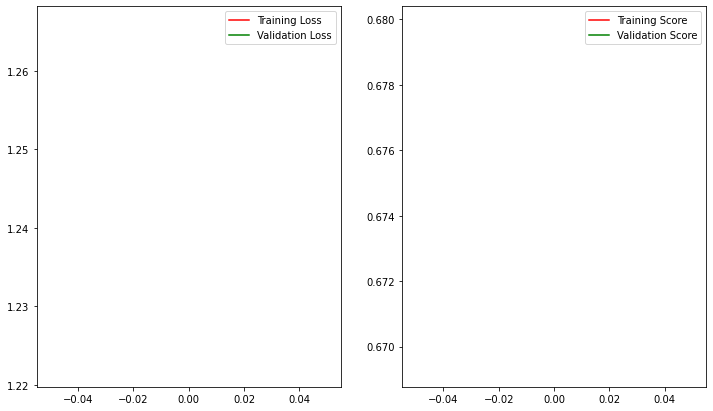

Iteration : 5


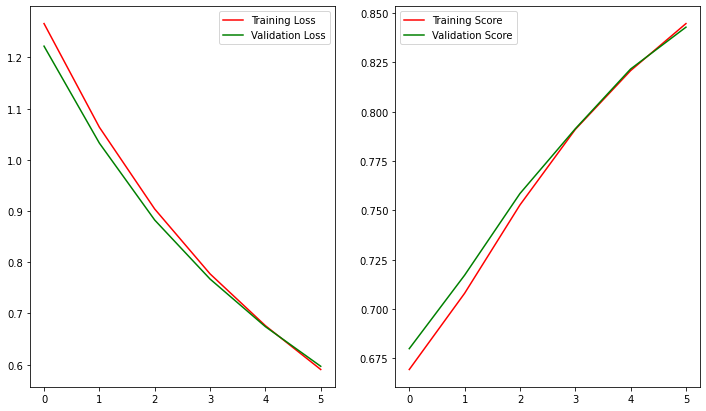

Iteration : 10


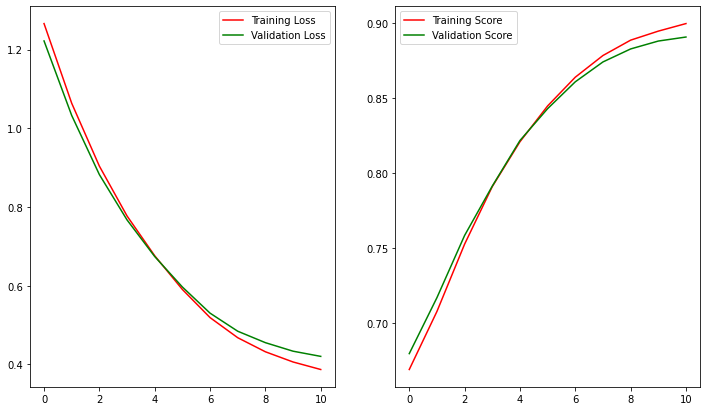

Iteration : 15


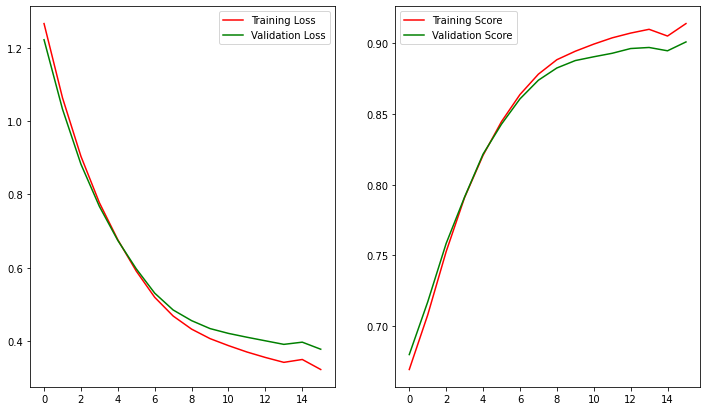

In [ ]:
trainer = train_model(train_loader,
                      test_loader,
                      'clf',
                      model,
                      optimizer,
                      loss_func,
                      16)
model, h = trainer.train_it()

# Evaluating

In [ ]:
model.eval()

myencdec(
  (enc): encoder(
    (emb): Embedding(59, 88)
    (rnn): LSTM(88, 100, batch_first=True, dropout=0.2)
    (fc): Linear(in_features=100, out_features=82, bias=True)
  )
  (dec): decoderattn(
    (emb): Embedding(82, 82)
    (rnn): LSTM(164, 100, batch_first=True)
    (attn): attn(
      (U): Linear(in_features=82, out_features=82, bias=True)
      (W): Linear(in_features=100, out_features=82, bias=True)
      (attn_f): Linear(in_features=82, out_features=1, bias=True)
    )
    (fc): Linear(in_features=100, out_features=82, bias=True)
  )
)

In [ ]:
for X in test_loader:
    out =model(X)
    for idx in list(np.arange(127)):
      inv_dict = dict(zip(d_output.values(), d_output.keys()))
      print(''.join([inv_dict[j.item()] for j in torch.argmax(out[idx],axis=1)]))
      print(''.join([inv_dict[j.item()] for j in X[2][idx]]))
      print('==============================================')
        
        

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Streaming output truncated to the last 5000 lines.
डेजी<EOS><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
भगवनन<EOS><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
भगवान<EOS><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
इरफान<EOS><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
इरफान<EOS><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
खालिका<PAD><PAD><PAD><PAD><PAD><PAD><PAD>
खालिक<EOS><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
मुतासिम<EOS><PAD><PAD><PAD><PAD><PAD>
मुतासिम<EOS><PAD><PAD><PAD><PAD><PAD>
भूल<EOS><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
खून<EOS><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
जतार<EOS><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
जठार<EOS><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
क्लिंटन<EOS><PAD><PAD><PAD><PAD><PAD>
क्लिंटन<EOS><PAD><PAD><PAD><PAD><PAD>
मिशाल<EOS><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
मिशेल<EOS><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
डुनिया<EOS><PAD><PAD><PAD><PAD><PAD><PAD>
दुनिया<EOS><PAD><PAD><PAD><PAD><PAD><PAD>
कॉर्पोरेशन<EOS><PAD><PAD>
कॉर्पोरेशन<EOS><PAD><PAD>
स्प्ेल<PAD><PAD><PAD><PAD><PAD><PAD><PA

In [ ]:
for idx in list(np.arange(127)):
  inv_dict = dict(zip(d_output.values(), d_output.keys()))
  print(''.join([inv_dict[j.item()] for j in torch.argmax(out[idx],axis=1)]))
  print(''.join([inv_dict[j.item()] for j in X[2][idx]]))
  print('==============================================')

नाग<EOS><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
नाग<EOS><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
अम्ररर्टो<EOS><PAD><PAD><PAD>
अम्बेर्टो<EOS><PAD><PAD><PAD>
गोाा<EOS><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
गोवा<EOS><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
गोकुल<EOS><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
गोकुल<EOS><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
फीर<EOS><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
पीर<EOS><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
बेस्टन<EOS><PAD><PAD><PAD><PAD><PAD><PAD>
वेस्टन<EOS><PAD><PAD><PAD><PAD><PAD><PAD>
नकली<EOS><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
नकली<EOS><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
थुर्ववरर्ड<EOS><PAD><PAD>
थुर्नवाल्ड<EOS><PAD><PAD>
बरराबाला<EOS><PAD><PAD><PAD><PAD>
व्रजबाला<EOS><PAD><PAD><PAD><PAD>
बाी<EOS><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
बकी<EOS><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
पराय<EOS><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
पराए<EOS><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
स्टेी<EOS><PAD><PAD>

# Testing

In [ ]:
for letter in 'index'.split(' '):
  fortest = mydata([letter],['1111111111111'])
  fortestload = DataLoader(fortest,1,collate_fn=padder)
  s = ''
  for X in fortestload:
    out,h0,c0 = model.enc(X[0],X[3])
    print(X[1].shape)
    o,a,h1,c1 = model.dec(out,X[1][:,0],h0,c0)
    
    # o = torch.argmax(o,axis=-1).squeeze(1)
    s = inv_dict[torch.argmax(o).item()]
    A = a
    for i in range(10):

        # print(o)
        o = torch.argmax(o,axis=-1).squeeze(1)
        o,a,h1,c1 = model.dec(out,o,h1,c1)
        id = torch.argmax(o)
        s = s + inv_dict[torch.argmax(o).item()]
        A =torch.cat((A,a))
        print(a.shape)
    print(s)

torch.Size([1, 14])
torch.Size([1, 6, 1])
torch.Size([1, 6, 1])
torch.Size([1, 6, 1])
torch.Size([1, 6, 1])
torch.Size([1, 6, 1])
torch.Size([1, 6, 1])
torch.Size([1, 6, 1])
torch.Size([1, 6, 1])
torch.Size([1, 6, 1])
torch.Size([1, 6, 1])
इंडेक्स<EOS><EOS><EOS><EOS>


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [ ]:
import skimage.io as io

In [ ]:
A.squeeze(2).detach().numpy().shape

(11, 6)

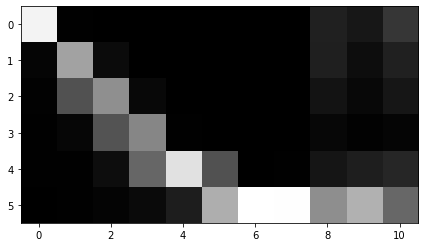

In [ ]:
io.imshow(A.squeeze(2).permute(1,0).detach().numpy())

In [ ]:
A.squeeze(2).detach().numpy()